In [1]:
import pandas as pd
import numpy as np
import time
import pickle
import torch

from sbi.utils import BoxUniform
from scipy.integrate import odeint

from sbi.utils import MultipleIndependent

import matplotlib.pyplot as plt

_ = np.random.seed(0)      

/etc/python/sitecustomize.py:236: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  mod = _original_import(name, globals, locals, fromlist, level)


In [2]:
with open('./data/M1_dataset.pkl', 'rb') as handle:
    sim_traj = pickle.load(handle)

with open('./data/M1_params.pkl', 'rb') as handle:
    sim_params = pickle.load(handle)

In [3]:
def poisson_noise(simulation):
    
    with_noise = np.random.poisson(np.maximum(simulation, 1e-6))

    return with_noise

In [4]:
traj_1k   = torch.tensor(poisson_noise(sim_traj[:1000].numpy()), dtype=torch.float32)
params_1k = sim_params[:1000]

traj_10k   = torch.tensor(poisson_noise(sim_traj[:10000].numpy()), dtype=torch.float32)
params_10k = sim_params[:10000]

traj_100k   = torch.tensor(poisson_noise(sim_traj[:100000].numpy()), dtype=torch.float32)
params_100k = sim_params[:100000]

In [5]:
with open('../sim_dataset.pkl', 'rb') as f:
    simulation_dataset = pickle.load(f)

In [6]:
from sbi.utils import BoxUniform
from scipy.integrate import odeint
from sbi.utils import MultipleIndependent

import torch
from torch.distributions import Uniform, Exponential, Cauchy

_ = torch.manual_seed(0)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [7]:
import torch.nn as nn
from sbi.inference import NPE
from sbi.neural_nets import posterior_nn
from torch.distributions import transforms

In [8]:
low  = torch.tensor([0.2, 0.1, 0.05])
high = torch.tensor([1.5, 0.5, 0.4])

prior = BoxUniform(low=low, high=high)

In [9]:
xs_1k     = traj_1k
thetas_1k = params_1k

In [10]:
neural_posterior = posterior_nn(model='nsf')

In [11]:
inference = NPE(density_estimator=neural_posterior,device=device)

# training
start_time = time.time()
density_estimator_1k=inference.append_simulations(thetas_1k, xs_1k).train(training_batch_size=64)
end_time = time.time() 
elapsed_time = end_time - start_time
print(f"time.time(): {elapsed_time:.4f} seconds")

 Neural network successfully converged after 122 epochs.time.time(): 43.6689 seconds


In [12]:
posterior_1k = inference.build_posterior(density_estimator_1k)

with open("./network/M1_1k_nsf_posterior.pkl", "wb") as handle:
    pickle.dump(posterior_1k, handle)

with open("./network/M1_1k_nsf_inference.pkl", "wb") as handle:
    pickle.dump(inference, handle)

/tmp/ipykernel_3042863/1184181790.py:7: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickle.dump(inference, handle)


In [13]:
import os
import glob

In [14]:
xlsx_files = sorted(glob.glob(os.path.join('../BayesianFit/output/','*.xlsx')))
posterior_ref = [pd.read_excel(file) for file in xlsx_files]

In [15]:
param_names=['beta','kappa','gamma']

  0%|          | 0/10000 [00:00<?, ?it/s]/home/gjang12/.conda/envs/sbi_env/lib/python3.11/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2190.)
  outputs, _ = torch.triangular_solve(
100%|██████████| 10000/10000 [00:00<00:00, 57418.23it/s]


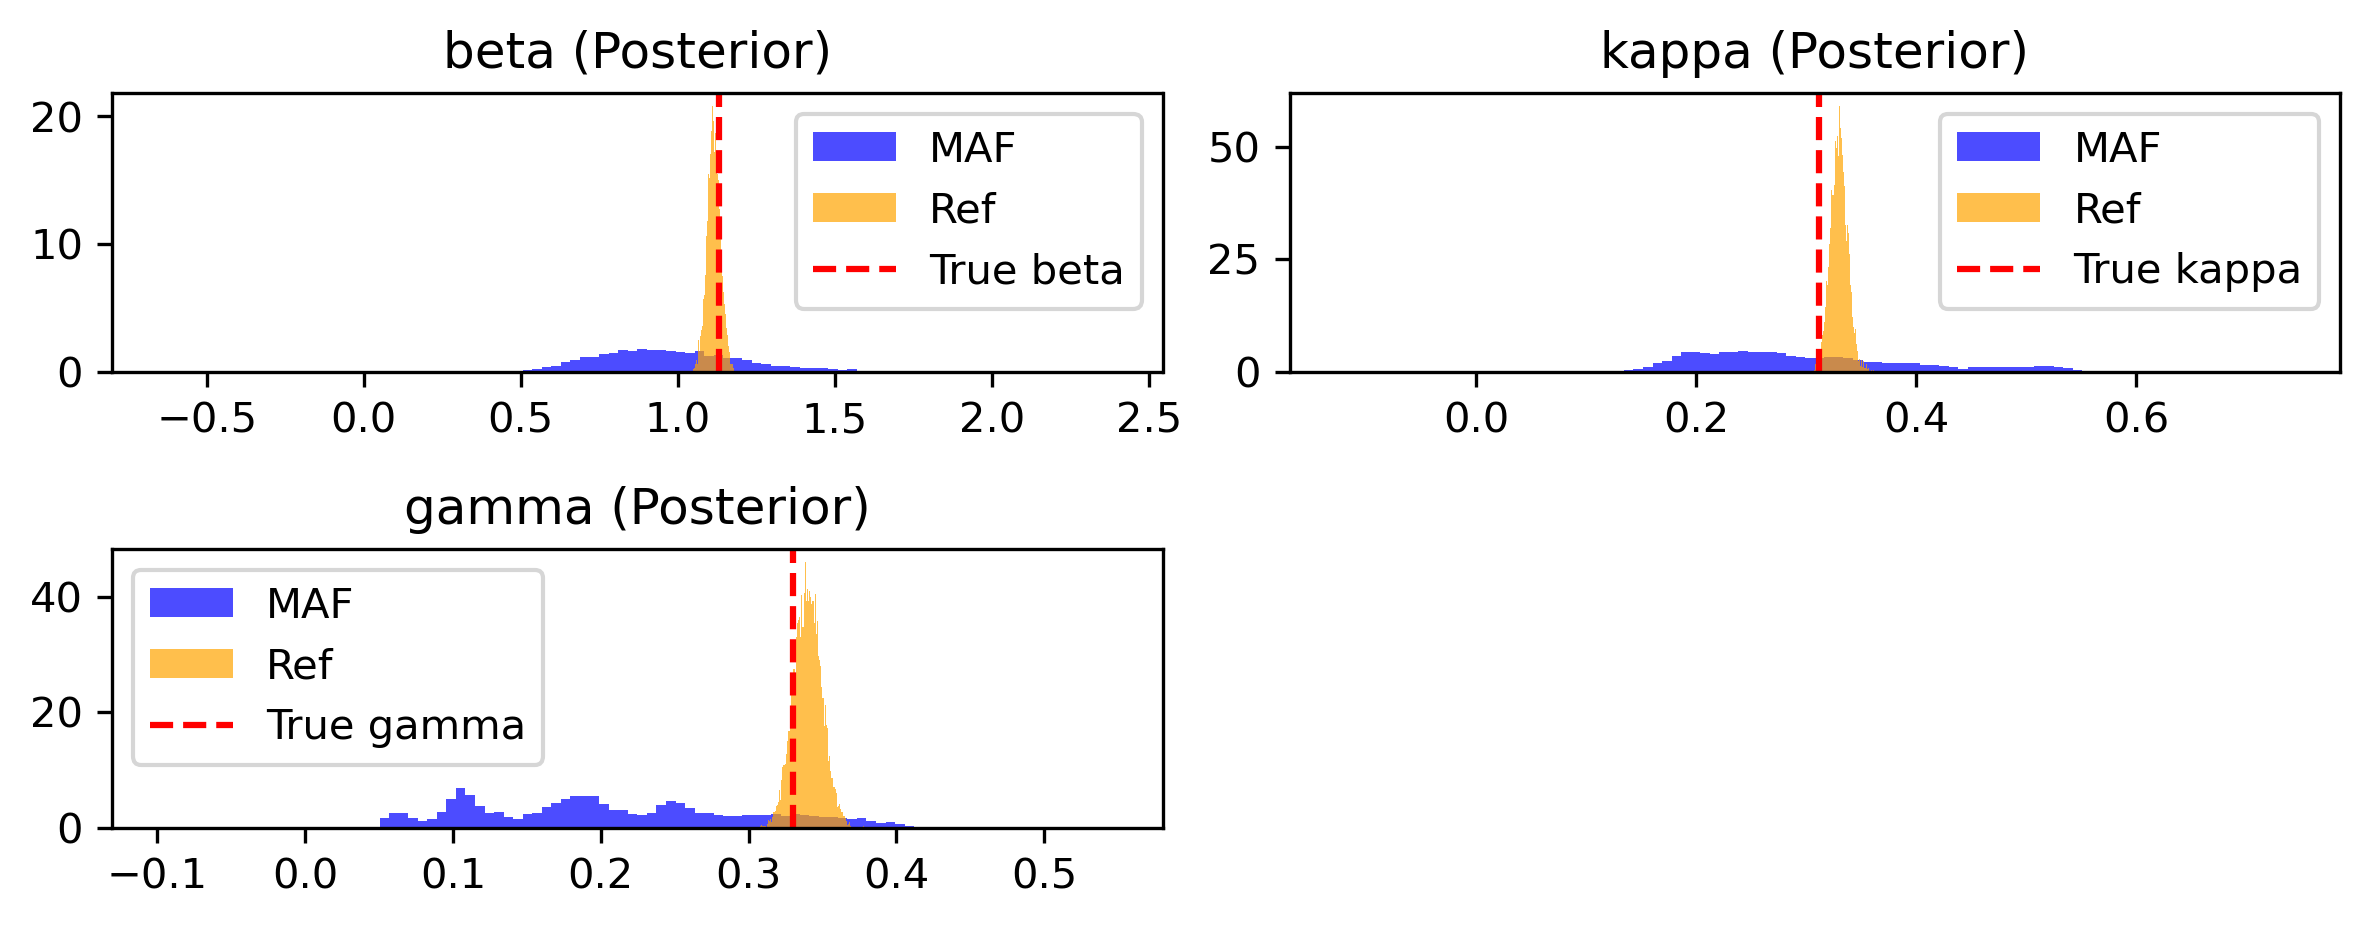

In [16]:
k = 1

x_obs = torch.as_tensor(simulation_dataset[k]['poisson'][:,0], dtype=torch.float32).to(device)

samples = posterior_1k.sample((10000,), x=x_obs)
df_1k=pd.DataFrame(samples, columns=['beta','kappa','gamma'])
ref_samples = posterior_ref[k]
npe_samples = df_1k
true_values = simulation_dataset[k]['params']

plt.figure(figsize=(8, 6),dpi=300)
for i in range(3):
    plt.subplot(4, 2, i + 1)
    plt.hist(npe_samples.iloc[:,i], bins=100, alpha=0.7, label="MAF", color='blue', density=True)
    plt.hist(ref_samples.iloc[:,i], bins=100, alpha=0.7, label="Ref", color='orange', density=True)
    plt.axvline(true_values[param_names[i]], color='red', linestyle='--', label=f"True {param_names[i]}")
    plt.title(f"{param_names[i]} (Posterior)")
    plt.legend()

plt.tight_layout()
plt.show()

In [17]:
from sbi.diagnostics import run_sbc, check_sbc
from sbi.analysis import sbc_rank_plot

In [18]:
num_sbc_samples = 200
theta_sbc = thetas_1k[:num_sbc_samples]
x_sbc = xs_1k[:num_sbc_samples]

# 2. SBC 실행 (각 데이터마다 사후분포 샘플 1,000개씩 추출하여 랭크 계산)
ranks, dap_samples = run_sbc(
    theta_sbc, 
    x_sbc, 
    posterior_1k, 
    num_posterior_samples=1000
)

/home/gjang12/.conda/envs/sbi_env/lib/python3.11/site-packages/sbi/utils/diagnostics_utils.py:45: UserWarning: Capping max_sampling_batch_size from 10000 to 500 to avoid excessive memory usage.
  posterior_samples = posterior.sample_batched(
Calculating ranks for 200 SBC samples: 100%|██████████| 200/200 [00:00<00:00, 11825.27it/s]


In [19]:
check_stats = check_sbc(
    ranks, theta_sbc, dap_samples, num_posterior_samples=1000
)

In [20]:
print(
    f"""kolmogorov-smirnov p-values \n
    check_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"""
)

kolmogorov-smirnov p-values 

    check_stats['ks_pvals'] = [0.35156205 0.8758684  0.26823327]


In [21]:
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

c2st accuracies 
check_stats['c2st_ranks'] = [0.5275 0.485  0.55  ]


In [22]:
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")

- c2st accuracies check_stats['c2st_dap'] = [0.5525 0.56   0.5625]


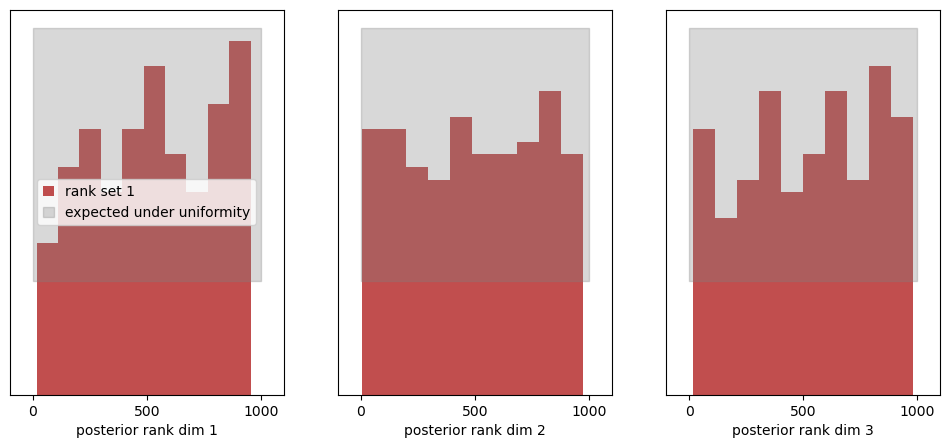

In [23]:
f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=1000,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)

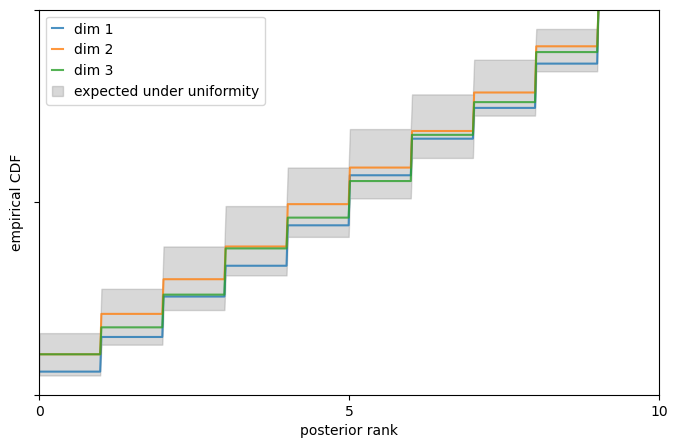

In [24]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")

In [25]:
xs_10k     = traj_10k
thetas_10k = params_10k

In [26]:
neural_posterior = posterior_nn(model='nsf')

In [27]:
inference = NPE(density_estimator=neural_posterior,device=device)

# training
start_time = time.time()
density_estimator_10k=inference.append_simulations(thetas_10k, xs_10k).train(training_batch_size=128)
end_time = time.time() 
elapsed_time = end_time - start_time
print(f"time.time(): {elapsed_time:.4f} seconds")

 Neural network successfully converged after 162 epochs.time.time(): 315.7604 seconds


In [28]:
posterior_10k = inference.build_posterior(density_estimator_10k)

with open("./network/M1_10k_nsf_posterior.pkl", "wb") as handle:
    pickle.dump(posterior_10k, handle)

with open("./network/M1_10k_nsf_inference.pkl", "wb") as handle:
    pickle.dump(inference, handle)

/tmp/ipykernel_3042863/2600603492.py:7: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickle.dump(inference, handle)


100%|██████████| 10000/10000 [00:00<00:00, 154078.86it/s]


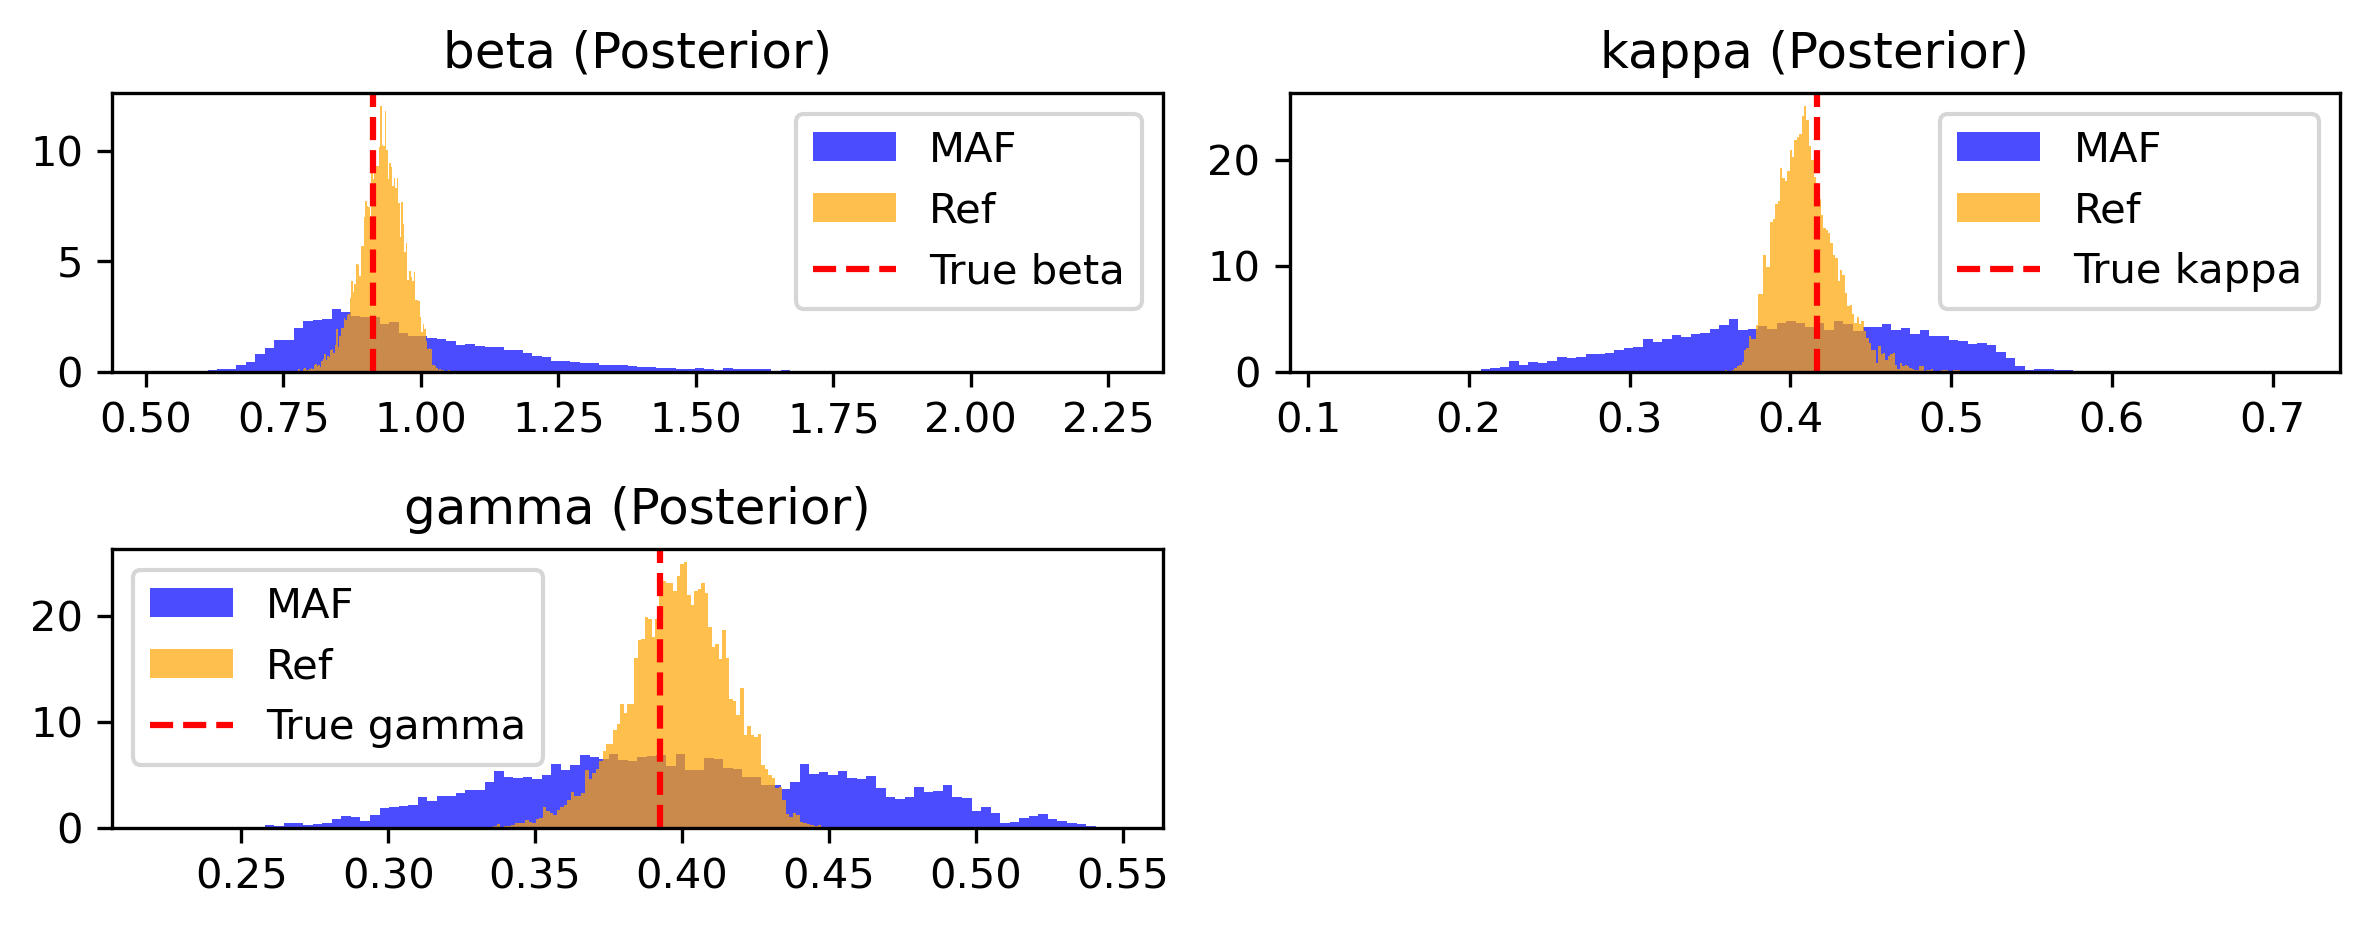

In [29]:
k = 0

x_obs = torch.as_tensor(simulation_dataset[k]['poisson'][:,0], dtype=torch.float32).to(device)
samples = posterior_10k.sample((10000,), x=x_obs)

df_1k=pd.DataFrame(samples, columns=['beta','kappa','gamma'])
ref_samples = posterior_ref[k]
npe_samples = df_1k
true_values = simulation_dataset[k]['params']

plt.figure(figsize=(8, 6),dpi=300)
for i in range(3):
    plt.subplot(4, 2, i + 1)
    plt.hist(npe_samples.iloc[:,i], bins=100, alpha=0.7, label="MAF", color='blue', density=True)
    plt.hist(ref_samples.iloc[:,i], bins=100, alpha=0.7, label="Ref", color='orange', density=True)
    plt.axvline(true_values[param_names[i]], color='red', linestyle='--', label=f"True {param_names[i]}")
    plt.title(f"{param_names[i]} (Posterior)")
    plt.legend()

plt.tight_layout()
plt.show()

In [30]:
num_sbc_samples = 200
theta_sbc = thetas_10k[:num_sbc_samples]
x_sbc = xs_10k[:num_sbc_samples]

# 2. SBC 실행 (각 데이터마다 사후분포 샘플 1,000개씩 추출하여 랭크 계산)
ranks, dap_samples = run_sbc(
    theta_sbc, 
    x_sbc, 
    posterior_10k, 
    num_posterior_samples=1000
)

/home/gjang12/.conda/envs/sbi_env/lib/python3.11/site-packages/sbi/utils/diagnostics_utils.py:45: UserWarning: Capping max_sampling_batch_size from 10000 to 500 to avoid excessive memory usage.
  posterior_samples = posterior.sample_batched(
Calculating ranks for 200 SBC samples: 100%|██████████| 200/200 [00:00<00:00, 11588.88it/s]


In [31]:
check_stats = check_sbc(
    ranks, theta_sbc, dap_samples, num_posterior_samples=1000
)

In [32]:
print(
    f"""kolmogorov-smirnov p-values \n
    check_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"""
)

kolmogorov-smirnov p-values 

    check_stats['ks_pvals'] = [0.49345088 0.12841468 0.7039972 ]


In [33]:
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

c2st accuracies 
check_stats['c2st_ranks'] = [0.5225 0.49   0.5475]


In [34]:
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")

- c2st accuracies check_stats['c2st_dap'] = [0.4625 0.535  0.535 ]


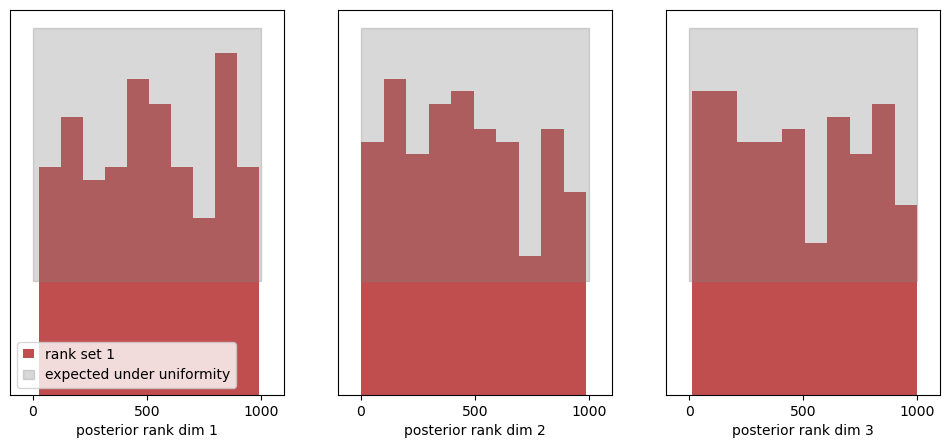

In [35]:
f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=1000,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)

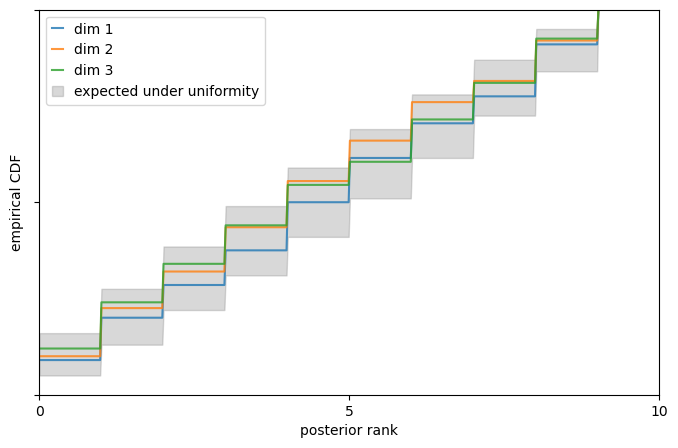

In [36]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")

In [37]:
xs_100k     = traj_100k
thetas_100k = params_100k

In [38]:
neural_posterior = posterior_nn(model='nsf')

In [39]:
inference = NPE(density_estimator=neural_posterior,device=device)

# training
start_time = time.time()
density_estimator_100k=inference.append_simulations(thetas_100k, xs_100k).train(training_batch_size=256)
end_time = time.time() 
elapsed_time = end_time - start_time
print(f"time.time(): {elapsed_time:.4f} seconds")

 Neural network successfully converged after 151 epochs.time.time(): 1787.4954 seconds


In [40]:
posterior_100k = inference.build_posterior(density_estimator_100k)

with open("./network/M1_100k_nsf_posterior.pkl", "wb") as handle:
    pickle.dump(posterior_100k, handle)

with open("./network/M1_100k_nsf_inference.pkl", "wb") as handle:
    pickle.dump(inference, handle)

/tmp/ipykernel_3042863/912837276.py:7: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickle.dump(inference, handle)


100%|██████████| 10000/10000 [00:00<00:00, 164070.08it/s]


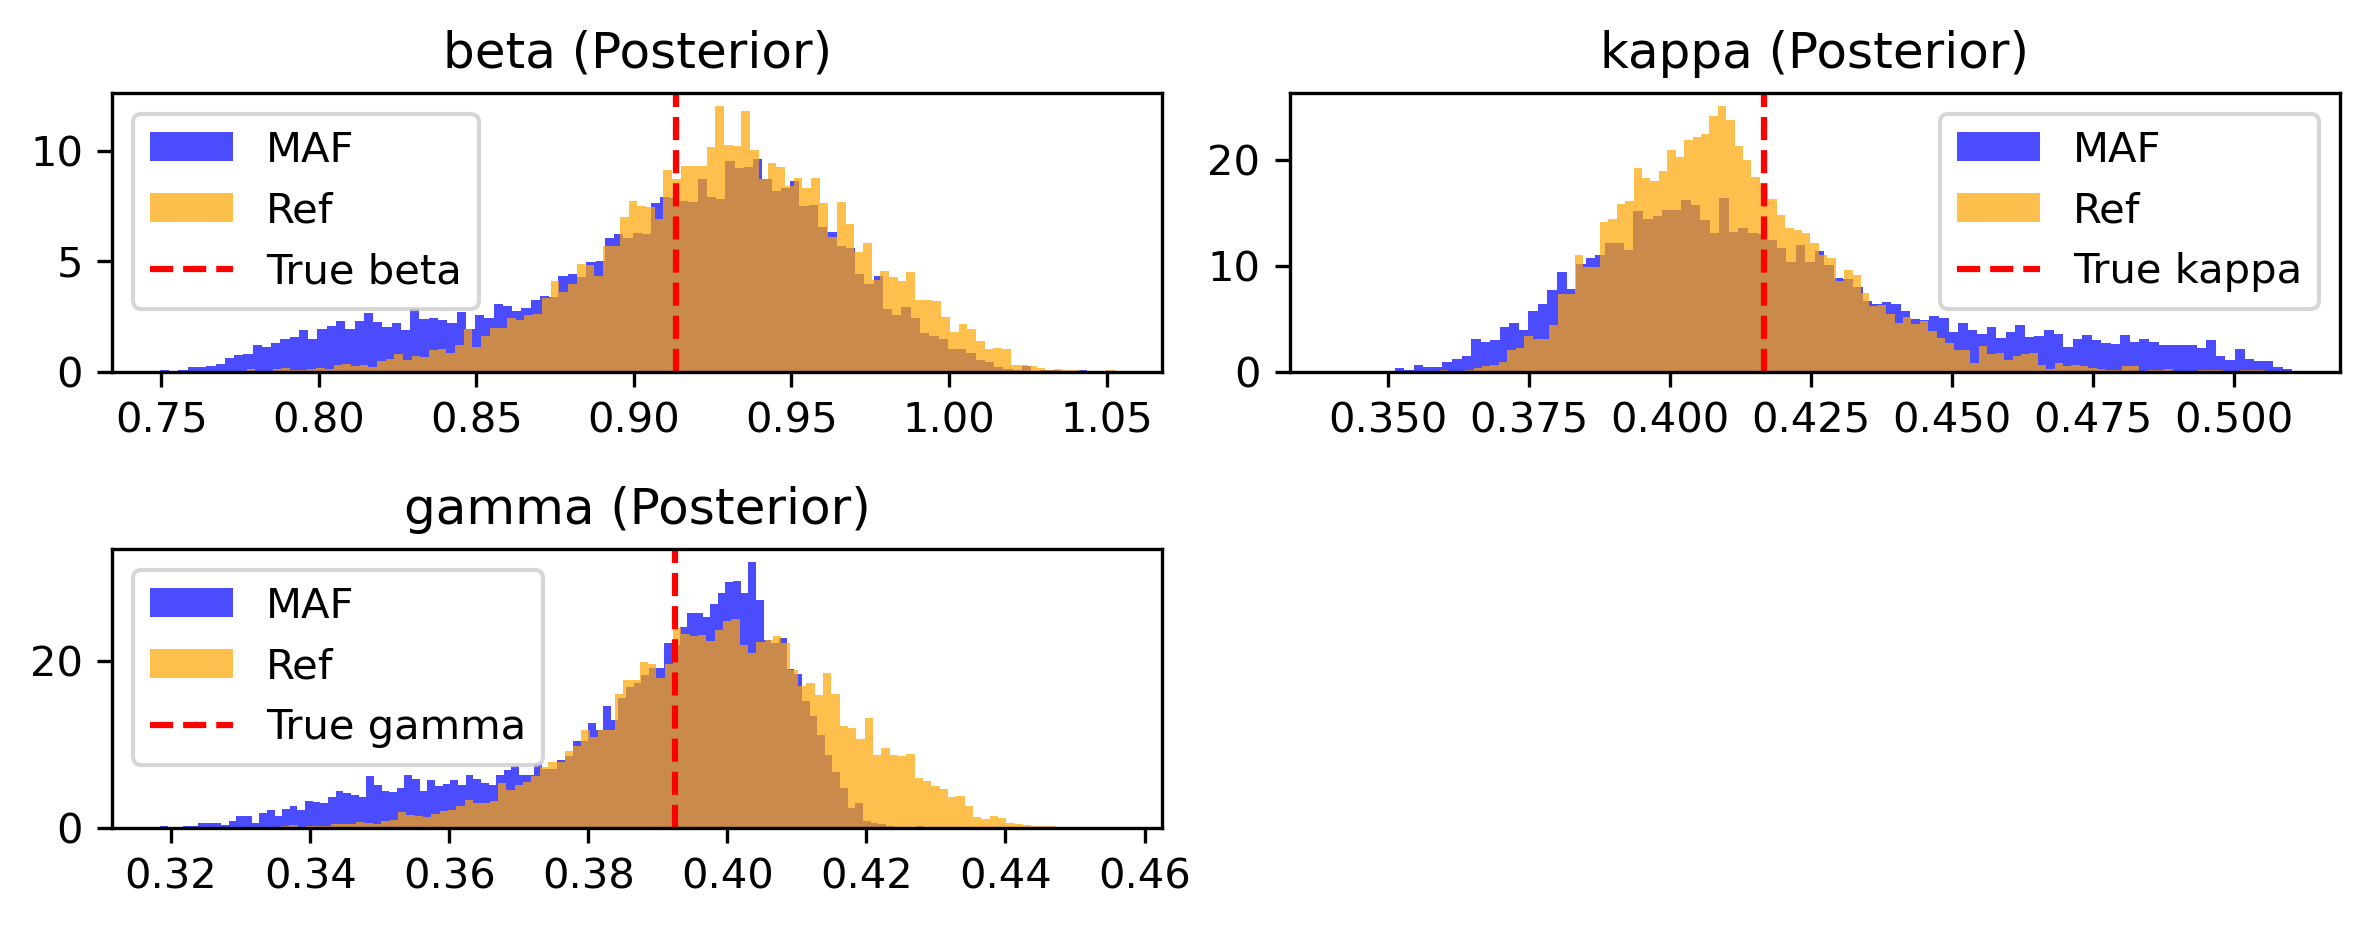

In [41]:
k = 0

x_obs = torch.as_tensor(simulation_dataset[k]['poisson'][:,0], dtype=torch.float32).to(device)
samples = posterior_100k.sample((10000,), x=x_obs)

df_1k=pd.DataFrame(samples, columns=['beta','kappa','gamma'])
ref_samples = posterior_ref[k]
npe_samples = df_1k
true_values = simulation_dataset[k]['params']

plt.figure(figsize=(8, 6),dpi=300)
for i in range(3):
    plt.subplot(4, 2, i + 1)
    plt.hist(npe_samples.iloc[:,i], bins=100, alpha=0.7, label="MAF", color='blue', density=True)
    plt.hist(ref_samples.iloc[:,i], bins=100, alpha=0.7, label="Ref", color='orange', density=True)
    plt.axvline(true_values[param_names[i]], color='red', linestyle='--', label=f"True {param_names[i]}")
    plt.title(f"{param_names[i]} (Posterior)")
    plt.legend()

plt.tight_layout()
plt.show()

In [42]:
num_sbc_samples = 200
theta_sbc = thetas_100k[:num_sbc_samples]
x_sbc = xs_100k[:num_sbc_samples]

ranks, dap_samples = run_sbc(
    theta_sbc, 
    x_sbc, 
    posterior_100k, 
    num_posterior_samples=1000
)

/home/gjang12/.conda/envs/sbi_env/lib/python3.11/site-packages/sbi/utils/diagnostics_utils.py:45: UserWarning: Capping max_sampling_batch_size from 10000 to 500 to avoid excessive memory usage.
  posterior_samples = posterior.sample_batched(
Calculating ranks for 200 SBC samples: 100%|██████████| 200/200 [00:00<00:00, 11844.97it/s]


In [43]:
check_stats = check_sbc(
    ranks, theta_sbc, dap_samples, num_posterior_samples=1000
)

In [44]:
print(
    f"""kolmogorov-smirnov p-values \n
    check_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"""
)

kolmogorov-smirnov p-values 

    check_stats['ks_pvals'] = [0.14639613 0.09784435 0.8376047 ]


In [45]:
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

c2st accuracies 
check_stats['c2st_ranks'] = [0.4775 0.45   0.515 ]


In [46]:
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")

- c2st accuracies check_stats['c2st_dap'] = [0.4925 0.515  0.4925]


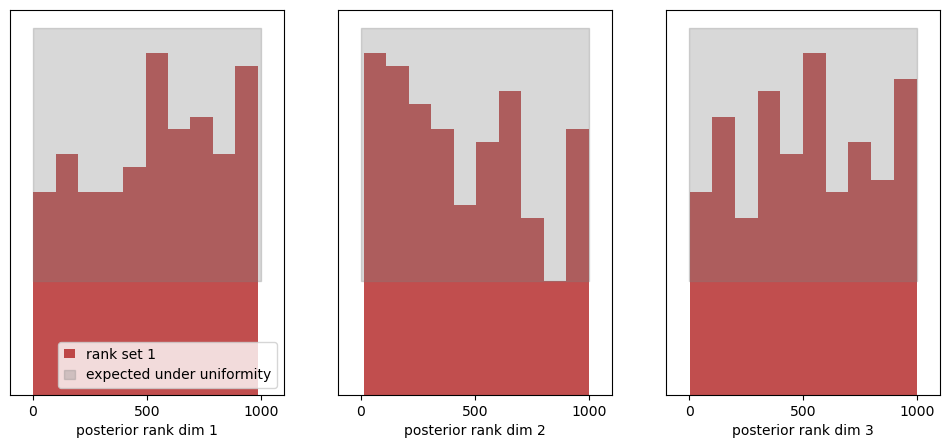

In [47]:
f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=1000,
    plot_type="hist",
    num_bins=None, 
)

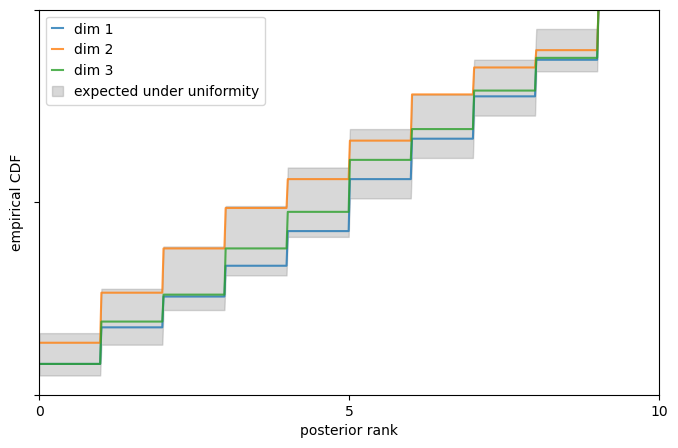

In [48]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")